In [1]:
from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.charge_extractors import *
from ctapipe.image.waveform_cleaning import BaselineWaveformCleaner

# Insert diretories manually (how to get them directly in the environment?)
sys.path.insert(0,'/astro/users/cassol/soft/python/cta-lstchain')
sys.path.insert(0,'/astro/users/cassol/soft/python/ctapipe_io_lstchain')

# a flat field run (for the moment to big for cta-lstchain-extra)
file = "/ctadata/franca/LST/LST-1.4.Run00167.0001.fits.fz"
run =167

reader = event_source(file, max_events=100)

channel=['HG','LG']
tel_id=0 # hopefully it will be 1 for EvB v3

In [2]:
# read first event (I had problems with the EventSeeker, till to investigate)
for i, event in enumerate(reader): 
    if i==0:
        break
    

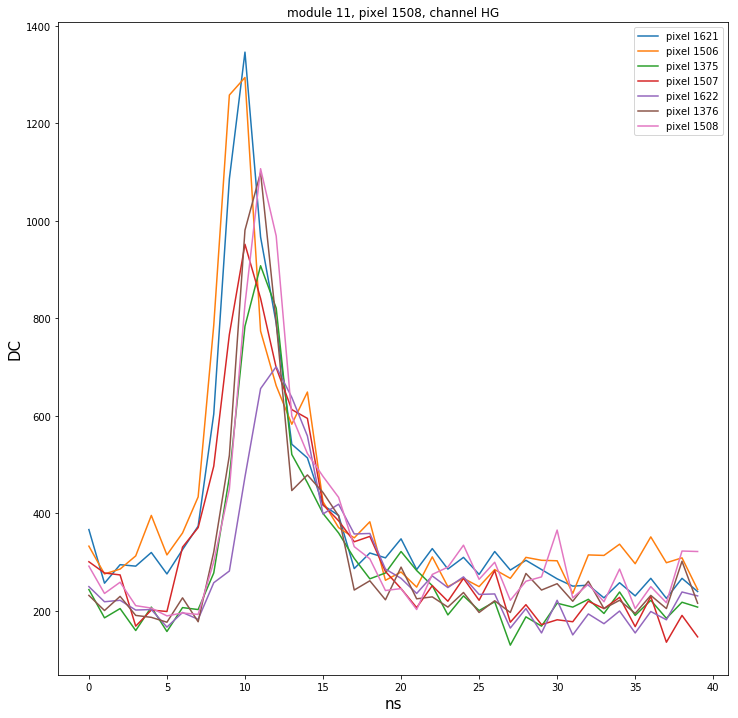

In [3]:
# plot R0 waveform of module
def view_waveform(chan=0, pix_id=6,i=0):
    waveform = event.r0.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {modu}, pixel {pix_id}, channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

    
modu=11
chan=0
fig = plt.figure(num=0,figsize=(12,12)) 
pixels_mod=event.lst.tel[0].svc.pixel_ids[modu*7:modu*7+7]
 
for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

channel HG: mean 3955.1498652291107 +- 1149.7864515982772


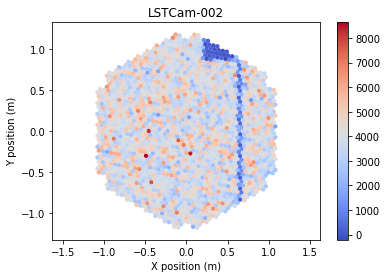

In [4]:
# integrate the charge after pedestal subtraction from values of some samples
# (to be replaced with information from pedestal events)

config = Config({
    "LocalPeakIntegrator": {
        "window_shift": 4,
        "window_width": 12 
    }
})
integrator = LocalPeakIntegrator(config=config)

# use the first 10 samples to estimate the baseline and subtract it (skip the first 2 samples)
config = Config({
    "BaselineWaveformCleaner": {
        "baseline_start": 32,
        "baseline_end":  38
    }
})


cleaner= BaselineWaveformCleaner(config=config)

# consider only 36 samples
waveform=event.r0.tel[0].waveform[:,:,2:38]
cleaned=cleaner.apply(waveform)

image, peakpos, window = integrator.extract_charge(cleaned)

disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()

print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")
 
#plt.savefig(f"Run{run}_event_{event.lst.tel[0].evt.event_id}.png")   

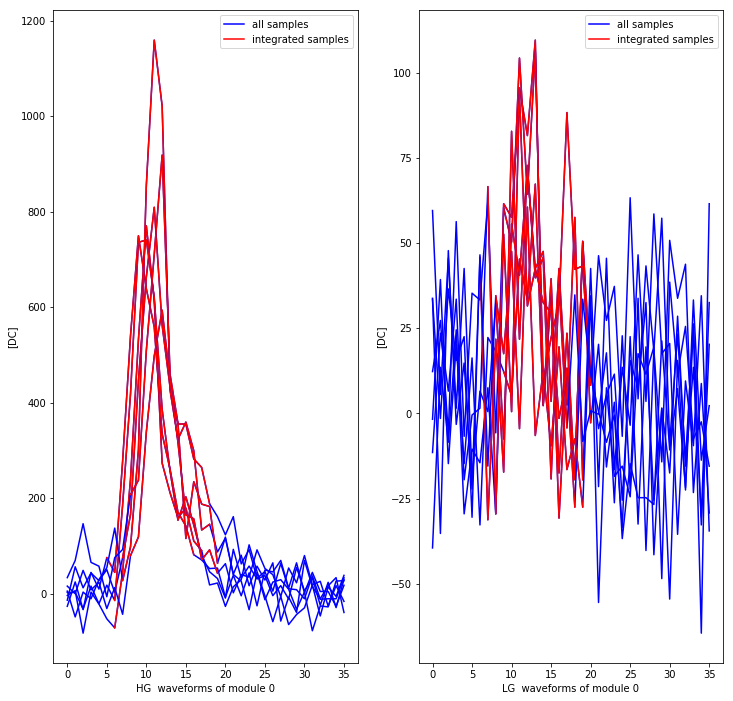

In [5]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0,figsize=(12,12))

# consider only 36 samples
samples=np.arange(0,36)

# chose the module
mod = 0

pix_in_mod = event.lst.tel[0].svc.pixel_ids[mod*7:mod*7+7]

for chan in(np.arange(2)): 

    plt.subplot(1,2,chan+1)
    
    for i,pix in enumerate(pix_in_mod):
    
        # samples used to calculate the charge
        used_window=window[chan,pix]
        used=cleaned[chan,pix,used_window]
        used_samples=samples[used_window]    
     
            
        plt.plot(cleaned[chan,pix,], color='b', label='all samples')
        plt.plot(used_samples,used, color='r', label='integrated samples')
        if i==0:
            plt.legend()
        plt.ylabel("[DC]")
        plt.xlabel(f"{channel[chan]}  waveforms of module {mod}")
        #fig.savefig(f"Run{run}_waverforms_module_{mod}.png")



get container after 100 events


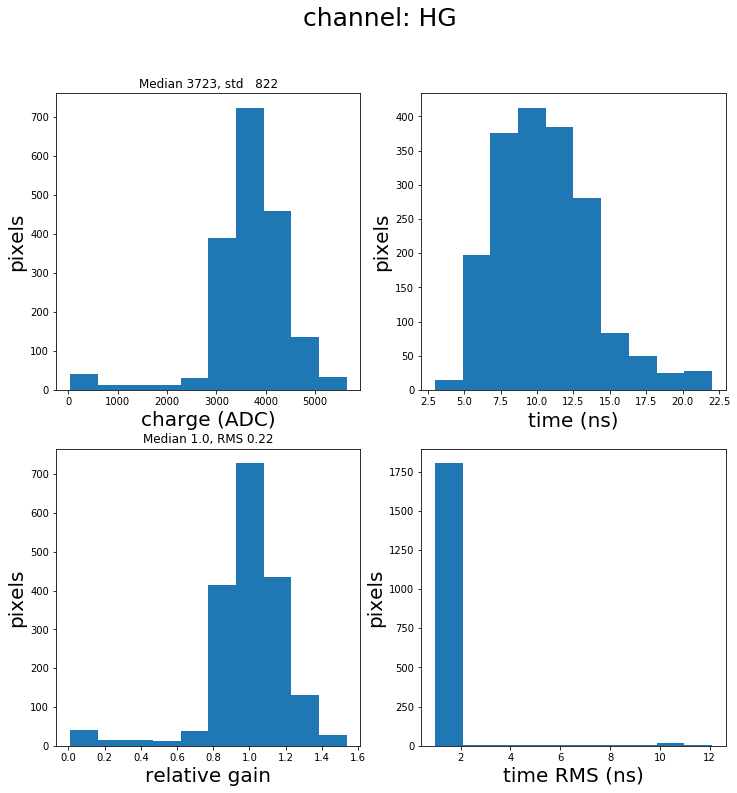

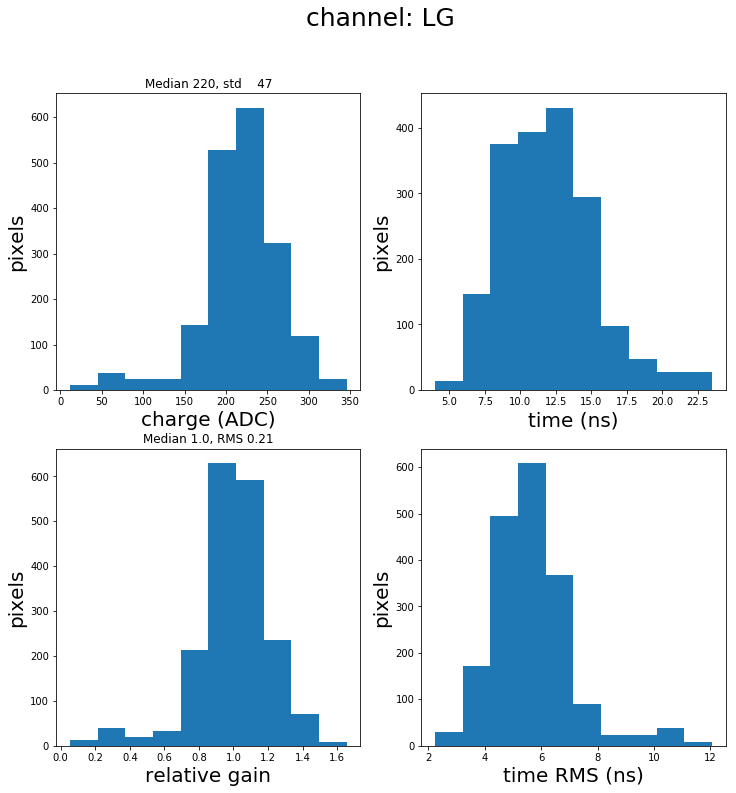

In [6]:
# flat field calculations

from lstchain.calib.camera.flatfield import FlasherFlatFieldCalculator


# configuration for the charge integrator
myconfig = Config({
    "LocalPeakIntegrator": {
        "window_shift": 4,
        "window_width": 10,
    }    
})


ff_calculator = FlasherFlatFieldCalculator(tel_id=0,
                                           sample_size=100,
                                           charge_product="LocalPeakIntegrator",
                                           config=myconfig)


for i, event in enumerate(reader): 
        
        # take away the baseline
        cleaned=cleaner.apply(event.r0.tel[0].waveform[:,:,2:38])
        event.r0.tel[0].waveform=cleaned
        
        ff_container = ff_calculator.calculate_relative_gain(event) 
        
        if(ff_container != None): # it return a FlatFieldCameraEvent each sample_size events
           print(f"get container after {i+1} events")
           for chan in np.arange(2):
               median_gain = ff_container.relative_gain_median[chan]
               median_relative_time = ff_container.relative_time_median[chan]
               median_charge = ff_container.charge_median[chan]
               rms_time = ff_container.time_std[chan]
               median_time = ff_container.time_median[chan]
        
               
               select=median_gain>-999999   
               #plt.title(f" channel {chan}")
               fig = plt.figure(chan,figsize=(12,12))
               fig.suptitle(f"channel: {channel[chan]}", fontsize=25) 
               plt.subplot(221)
               median= int(np.median(median_charge[select])) 
               std= np.std(median_charge[select])
               plt.title(f"Median {median}, std {std:5.0f}") 
               plt.xlabel('charge (ADC)',fontsize=20)
               plt.ylabel('pixels',fontsize=20) 
               plt.hist(median_charge[select])  
               plt.subplot(222)
               plt.ylabel('pixels',fontsize=20) 
               plt.xlabel('time (ns)',fontsize=20)            
               plt.hist(median_time[select])
        
               plt.subplot(223)
               plt.ylabel('pixels',fontsize=20) 
               plt.xlabel('relative gain',fontsize=20) 
               median= np.median(median_gain[select])
               rms= np.std(median_gain[select])
                
               plt.title(f"Median {median:3.2}, RMS {rms:3.2}") 
           
               plt.hist(median_gain[select])
               plt.subplot(224) 
               plt.ylabel('pixels',fontsize=20) 
               plt.xlabel('time RMS (ns)',fontsize=20)
           
               plt.hist(rms_time[select])
               s=median_charge[select]
               #plt.savefig(f"flatfield_{channel[chan]}.png")
        

In [7]:
# use the tool to write flat fields (still with partial waveform treatement)
from lstchain.tools.calc_flatfield import FlatFieldHDF5Writer
flatfield_tool= FlatFieldHDF5Writer()
flatfield_tool.print_help()

Generate a HDF5 file with flat field coefficients

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--input_file=<Unicode> (EventSource.input_url)
    Default: ''
    Path to the input file containing events.
--max_events=<Int> (EventSource.max_events)
    Default: None
    Maximum number of events that will be read from the file
--flatfield_calculator=<CaselessStrEnum> (FlatFieldHDF5Writer.calculator_product)
    Default: 'FlasherFlatFieldCalculator'
    Choices: ['FlasherFlatFieldCalculator']
    FlatFieldCalculator to use.
--tel_id=<Int> (FlatFieldCalculator.tel_id)
    Default: 0
    id of the telescope to calculate the flat-field coefficients
--sample_duration=<Int> (FlatFieldCalculator.sample_duration)
    Default: 60
    sample duration in seconds
--sample_size=<Int> (FlatFieldCalculator.sample_size)
    Default: 10000
    s

In [8]:
# 
flatfield_tool.run(argv=['--config','/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/flatfield_param.json'])

INFO [FlatFieldHDF5Writer] (tool/initialize): ctapipe version 0.6.1.post112+git4ee0824
INFO [FlatFieldHDF5Writer] (tool/run): Starting: FlatFieldHDF5Writer
DEBUG [FlatFieldHDF5Writer] (tool/run): CONFIG: {'FlatFieldHDF5Writer': {'config_file': '/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/flatfield_param.json', 'cleaner_product': 'BaselineWaveformCleaner', 'calculator_product': 'FlasherFlatFieldCalculator', 'output_file': '/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/flatfield.hdf5', 'log_level': 'DEBUG'}, 'EventSource': {'input_url': '/ctadata/franca/LST/LST-1.1.Run00168.0000.fits.fz', 'max_events': 100}, 'FlatFieldCalculator': {'sample_size': 90, 'sample_duration': 1000, 'tel_id': 0, 'charge_product': 'LocalPeakIntegrator'}, 'LocalPeakIntegrator': {'window_shift': 4, 'window_width': 10}, 'BaselineWaveformCleaner': {'baseline_start': 2, 'baseline_end': 7}}
INFO [FlatFieldHDF5Writer.FlasherFlatFieldCalculator] (flatfield/__init__): extractor <ctapipe.image

AttributeError: 'NoneType' object has no attribute 'meta'

In [ ]:
# read back the FlatFieldContainer container writen with the tool calc_flatfield.py
from ctapipe_io_lst.containers import FlatFieldContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
data = FlatFieldContainer()

with HDF5TableReader('/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/flatfield.hdf5') as h5_table:

    assert h5_table._h5file.isopen == True

    for cont in h5_table.read('/flatfield/tel_0', data):
            print(cont.charge_mean)
            print(cont.meta['config'])
assert h5_table._h5file.isopen == False